# Osobny autoenkoder dla każdego kanału na dataecie MSL

### Wczytanie danych

In [13]:
import pandas as pd
import numpy as np

# Wczytanie metadanych
metadata = pd.read_csv("labeled_anomalies.csv")
msl_channels = metadata[metadata['spacecraft'] == 'MSL']['chan_id'].tolist()

msl_train_data = {}
for channel in msl_channels:
    try:
        data = np.load(f"data/train/{channel}.npy")
        msl_train_data[channel] = data
    except FileNotFoundError:
        print(f"{channel}: brak danych")
    
msl_test_data = {}
for channel in msl_channels:
    try:
        data = np.load(f"data/test/{channel}.npy")
        msl_test_data[channel] = data
    except FileNotFoundError:
        print(f"{channel}: brak danych")

del data
del channel

### Funkcja tworzenia okien czasowych

In [14]:
def create_windows(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)


### Tworzenie okien czasowych dla pojedynczego kanału

In [15]:
from sklearn.preprocessing import MinMaxScaler

window_size = 10 
window_step = 1

# Wybór czujnika
sensor_name = msl_channels[8]
print(f"Wybrano czujnik: {sensor_name}")

train_data = msl_train_data[sensor_name]
# Normalizacja danych do przedziału [0, 1]
scaler = MinMaxScaler()
arr_norm = scaler.fit_transform(train_data)

# Tworzenie okien czasowych dla danych treningowych
arr_norm_windows = create_windows(arr_norm, window_size, window_step)

arr_norm_windows = arr_norm_windows.reshape(arr_norm_windows.shape[0], -1)
input_dim = arr_norm_windows.shape[1]  


del arr_norm, train_data


Wybrano czujnik: M-3


### Definicja modelu

In [16]:
import torch
from torch import nn, optim

if torch.cuda.is_available():
    print("GPU is available :)")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, using CPU. :(")
    device = torch.device("cpu")

class AE(nn.Module):
    def __init__(self, input_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),

        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

GPU is available :)


## Nauka na danych treningowych

In [17]:
from torch.utils.data import DataLoader, TensorDataset

epochs = 80
batch_size = 64

X_train = torch.tensor(arr_norm_windows, dtype=torch.float32).to(device)
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)

model = AE(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")



Epoch 10/80, Loss: 0.007982
Epoch 20/80, Loss: 0.007171
Epoch 30/80, Loss: 0.007075
Epoch 40/80, Loss: 0.006848
Epoch 50/80, Loss: 0.005024
Epoch 60/80, Loss: 0.003545
Epoch 70/80, Loss: 0.002909
Epoch 80/80, Loss: 0.002861


# Autoencoder na danych testowych

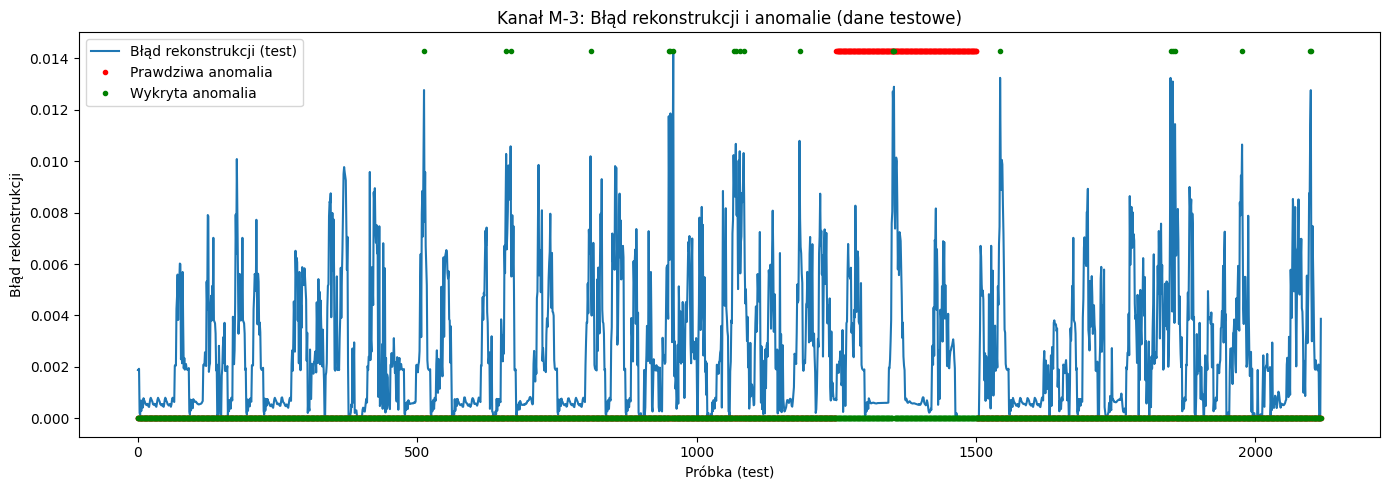

Confusion matrix (test):
[[1848   19]
 [ 248    3]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.88      0.99      0.93      1867
     Anomaly       0.14      0.01      0.02       251

    accuracy                           0.87      2118
   macro avg       0.51      0.50      0.48      2118
weighted avg       0.79      0.87      0.82      2118

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1500]: WYKRYTA


In [18]:
# Normalizacja oraz wczytanie danych testowych 
sensor_test_data = msl_test_data[sensor_name]
arr_test_norm = scaler.transform(sensor_test_data)
def create_windows(data, window_size):
    return np.array([data[i:i+window_size].flatten() for i in range(len(data) - window_size + 1)])
arr_test_norm_windows = create_windows(arr_test_norm, window_size)
X_test = torch.tensor(arr_test_norm_windows, dtype=torch.float32).to(device)

# Rekonstrukcja i obliczenie błędu rekonstrukcji na danych testowych
model.eval()
with torch.no_grad():
    recon = model(X_test).cpu().numpy()
recon_error = np.mean((arr_test_norm_windows - recon) ** 2, axis=1)   

# Wykrywanie anomalii na danych testowych
threshold = np.percentile(recon_error, 99)
predicted_anomaly = (recon_error > threshold).astype(int)

# Prawdziwe anomalie z labeled_anomalies.csv dla testowych indeksów
anomaly_row = metadata[metadata['chan_id'] == sensor_name]
anomaly_sequences = []
if not anomaly_row.empty:
    anomaly_sequences = eval(anomaly_row.iloc[0]['anomaly_sequences'])

true_anomaly = np.zeros(len(recon_error), dtype=int)   
for seq in anomaly_sequences:
    start, end = seq
    true_anomaly[start:min(end+1, len(true_anomaly))] = 1

# Wizualizacja wyników na danych testowych
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(14, 5))
plt.plot(recon_error, label="Błąd rekonstrukcji (test)")
plt.plot(true_anomaly * np.max(recon_error), 'r.', label="Prawdziwa anomalia")
plt.plot(predicted_anomaly * np.max(recon_error), 'g.', label="Wykryta anomalia")
plt.title(f"Kanał {sensor_name}: Błąd rekonstrukcji i anomalie (dane testowe)")
plt.xlabel("Próbka (test)")
plt.ylabel("Błąd rekonstrukcji")
plt.legend()
plt.tight_layout()
plt.show()

print("Confusion matrix (test):")
print(confusion_matrix(true_anomaly, predicted_anomaly))
print("\nClassification report (test):")
print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

# Sprawdzenie czy wykryto PRZYNAJMNIEJ JEDNĄ próbkę z każdej zdefiniowanej anomalii
detected_ranges = [] 
remaining_sequences = anomaly_sequences.copy()

for seq in anomaly_sequences:
    start, end = seq
    if np.any(predicted_anomaly[start:min(end+1, len(predicted_anomaly))] == 1):
        detected_ranges.append(seq)

# Wypisanie wyników
print("Wynik sprawdzania anomalii względem metadanych:")
for seq in anomaly_sequences:
    if seq in detected_ranges:
        print(f"Anomalia {seq}: WYKRYTA")
    else:
        print(f"Anomalia {seq}: NIEWYKRYTA")


# Dla wszystkich czujników MSL


Czujnik: M-6
Epoch 10/80, Loss: 0.008805
Epoch 20/80, Loss: 0.008947
Epoch 30/80, Loss: 0.008882
Epoch 40/80, Loss: 0.008929
Epoch 50/80, Loss: 0.009000
Epoch 60/80, Loss: 0.008988
Epoch 70/80, Loss: 0.008935
Epoch 80/80, Loss: 0.008900
Threshold (percentyl 95) na danych testowych: 311.512498


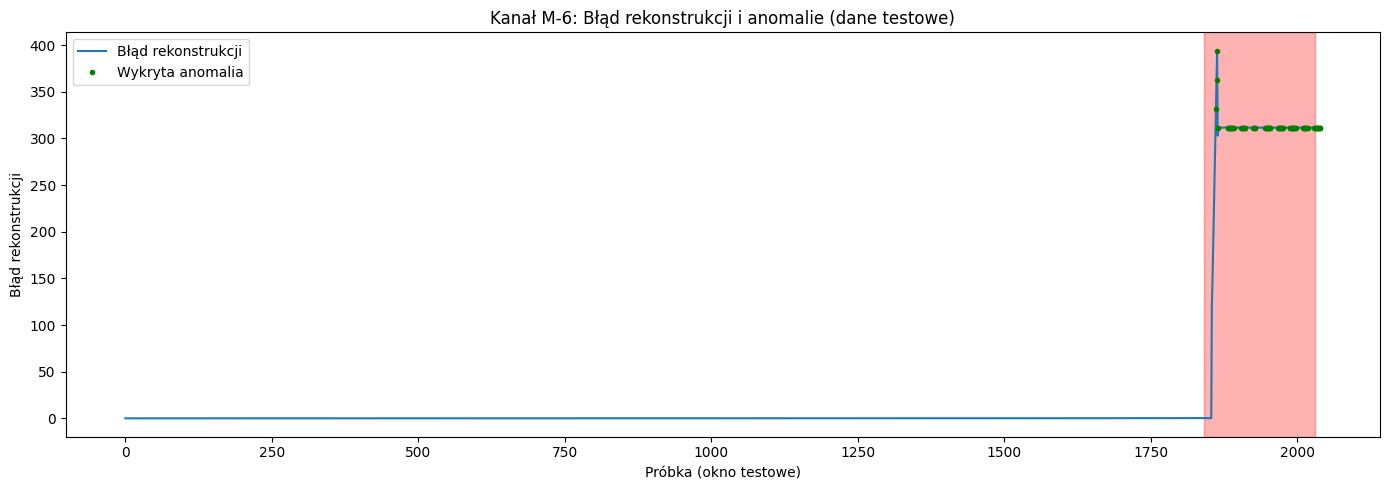

Confusion matrix (test):
[[1841   10]
 [ 124   65]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      1851
     Anomaly       0.87      0.34      0.49       189

    accuracy                           0.93      2040
   macro avg       0.90      0.67      0.73      2040
weighted avg       0.93      0.93      0.92      2040

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1850, 2030]: WYKRYTA

Czujnik: M-1
Epoch 10/80, Loss: 0.005425
Epoch 20/80, Loss: 0.004537
Epoch 30/80, Loss: 0.004051
Epoch 40/80, Loss: 0.003768
Epoch 50/80, Loss: 0.003319
Epoch 60/80, Loss: 0.002988
Epoch 70/80, Loss: 0.002832
Epoch 80/80, Loss: 0.002653
Threshold (percentyl 95) na danych testowych: 0.010136


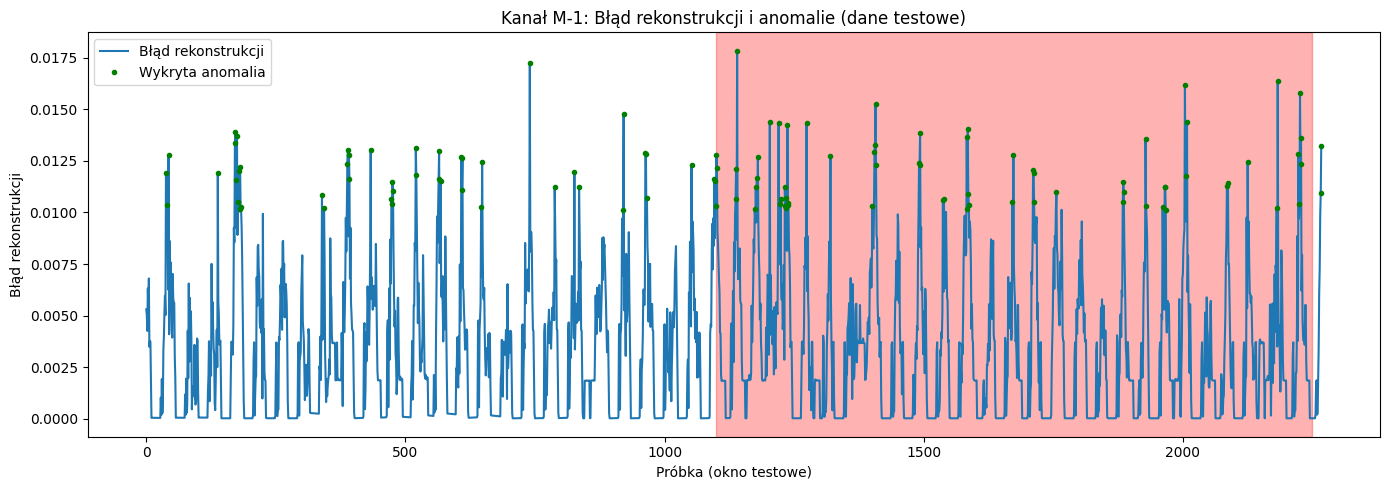

Confusion matrix (test):
[[1069   50]
 [1085   64]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.50      0.96      0.65      1119
     Anomaly       0.56      0.06      0.10      1149

    accuracy                           0.50      2268
   macro avg       0.53      0.51      0.38      2268
weighted avg       0.53      0.50      0.37      2268

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1110, 2250]: WYKRYTA

Czujnik: M-2
Epoch 10/80, Loss: 0.006337
Epoch 20/80, Loss: 0.006311
Epoch 30/80, Loss: 0.006342
Epoch 40/80, Loss: 0.006360
Epoch 50/80, Loss: 0.006318
Epoch 60/80, Loss: 0.006418
Epoch 70/80, Loss: 0.006289
Epoch 80/80, Loss: 0.006334
Threshold (percentyl 95) na danych testowych: 0.022912


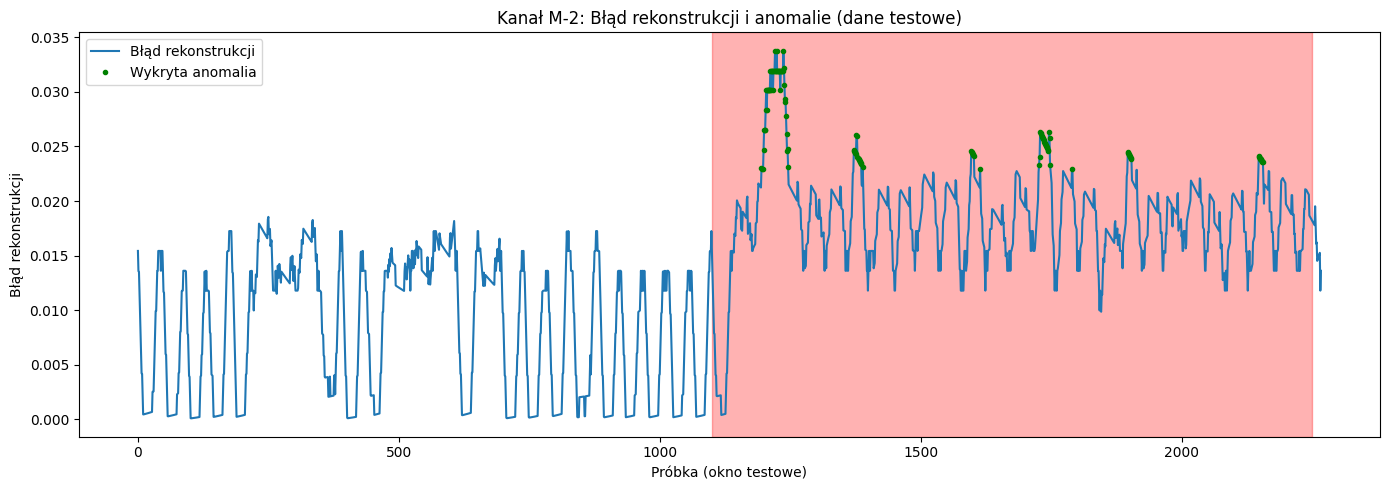

Confusion matrix (test):
[[1119    0]
 [1035  114]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.52      1.00      0.68      1119
     Anomaly       1.00      0.10      0.18      1149

    accuracy                           0.54      2268
   macro avg       0.76      0.55      0.43      2268
weighted avg       0.76      0.54      0.43      2268

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1110, 2250]: WYKRYTA

Czujnik: S-2
Epoch 10/80, Loss: 0.012894
Epoch 20/80, Loss: 0.012930
Epoch 30/80, Loss: 0.012758
Epoch 40/80, Loss: 0.012848
Epoch 50/80, Loss: 0.012885
Epoch 60/80, Loss: 0.012676
Epoch 70/80, Loss: 0.012848
Epoch 80/80, Loss: 0.012821
Threshold (percentyl 95) na danych testowych: 0.016364


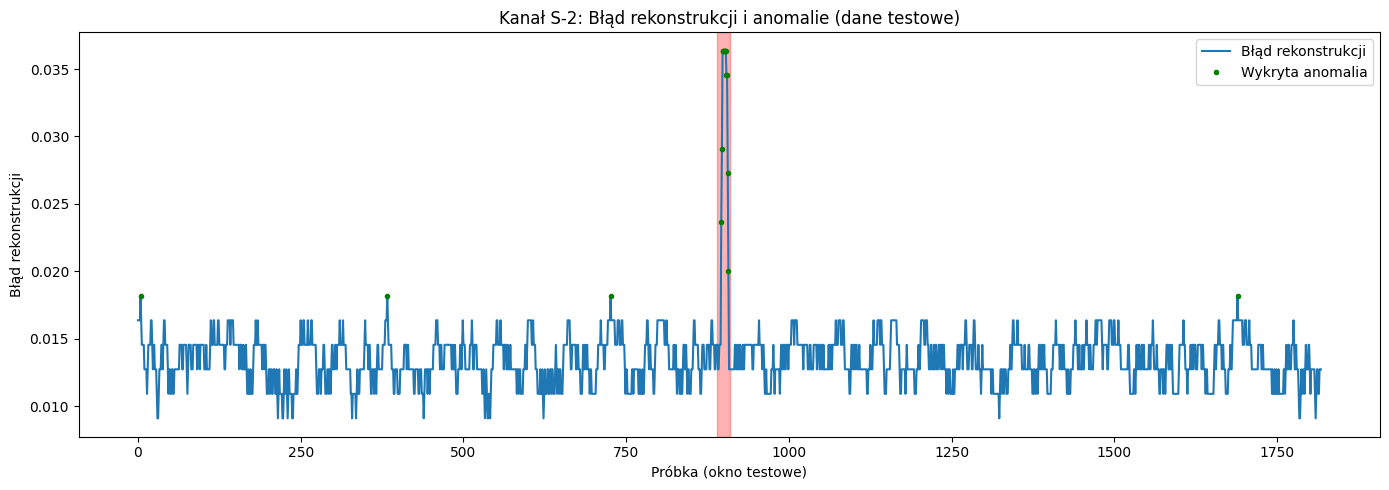

Confusion matrix (test):
[[1795    4]
 [   7   12]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1799
     Anomaly       0.75      0.63      0.69        19

    accuracy                           0.99      1818
   macro avg       0.87      0.81      0.84      1818
weighted avg       0.99      0.99      0.99      1818

Wynik sprawdzania anomalii względem metadanych:
Anomalia [900, 910]: WYKRYTA

Czujnik: P-10
Epoch 10/80, Loss: 0.002285
Epoch 20/80, Loss: 0.001766
Epoch 30/80, Loss: 0.001510
Epoch 40/80, Loss: 0.001652
Epoch 50/80, Loss: 0.001312
Epoch 60/80, Loss: 0.001475
Epoch 70/80, Loss: 0.001448
Epoch 80/80, Loss: 0.001704
Threshold (percentyl 95) na danych testowych: 237.345870


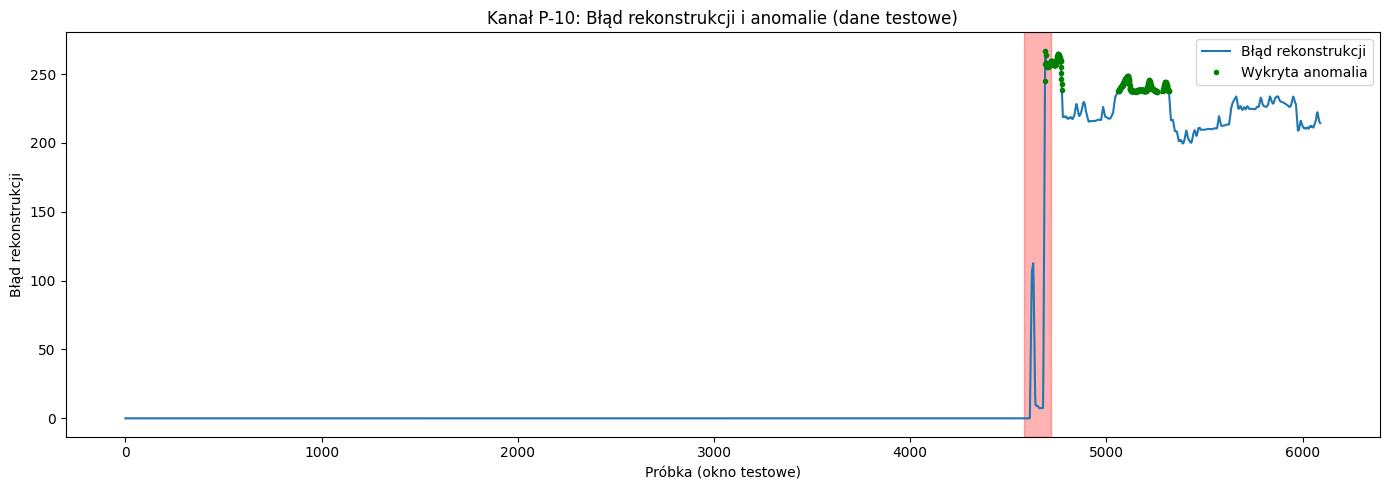

Confusion matrix (test):
[[5680  272]
 [ 106   33]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.97      5952
     Anomaly       0.11      0.24      0.15       139

    accuracy                           0.94      6091
   macro avg       0.54      0.60      0.56      6091
weighted avg       0.96      0.94      0.95      6091

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4590, 4720]: WYKRYTA

Czujnik: T-4
Epoch 10/80, Loss: 0.006402
Epoch 20/80, Loss: 0.006031
Epoch 30/80, Loss: 0.005159
Epoch 40/80, Loss: 0.004802
Epoch 50/80, Loss: 0.004694
Epoch 60/80, Loss: 0.004652
Epoch 70/80, Loss: 0.004621
Epoch 80/80, Loss: 0.004612
Threshold (percentyl 95) na danych testowych: 0.010926


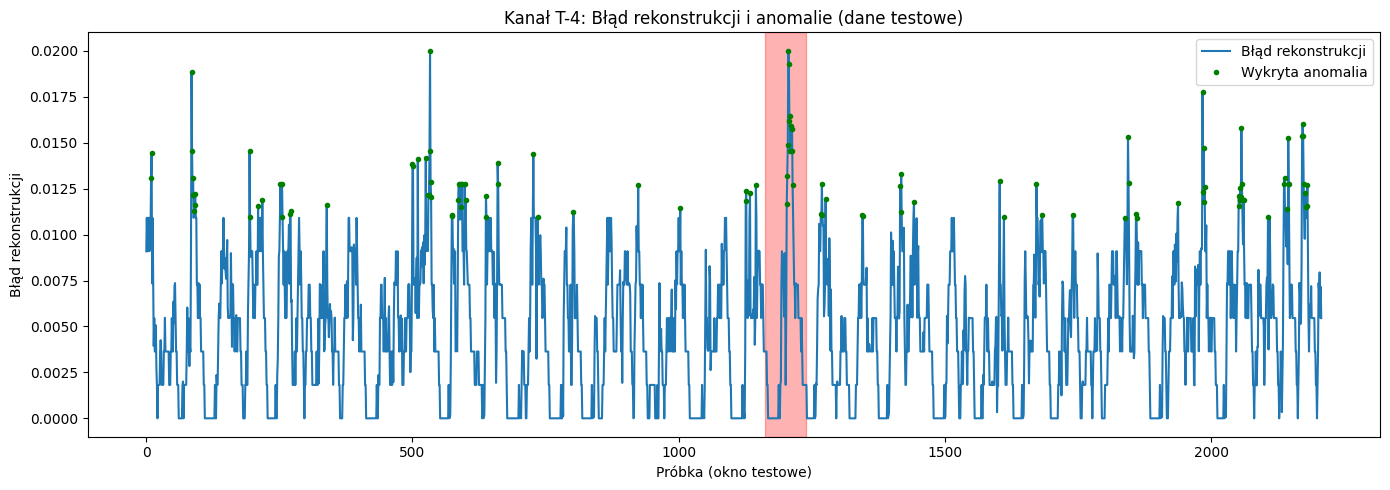

Confusion matrix (test):
[[2032   99]
 [  65   12]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96      2131
     Anomaly       0.11      0.16      0.13        77

    accuracy                           0.93      2208
   macro avg       0.54      0.55      0.54      2208
weighted avg       0.94      0.93      0.93      2208

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1172, 1240]: WYKRYTA

Czujnik: T-5
Epoch 10/80, Loss: 0.004861
Epoch 20/80, Loss: 0.004863
Epoch 30/80, Loss: 0.004877
Epoch 40/80, Loss: 0.004869
Epoch 50/80, Loss: 0.004871
Epoch 60/80, Loss: 0.004875
Epoch 70/80, Loss: 0.004868
Epoch 80/80, Loss: 0.004875
Threshold (percentyl 95) na danych testowych: 0.010909


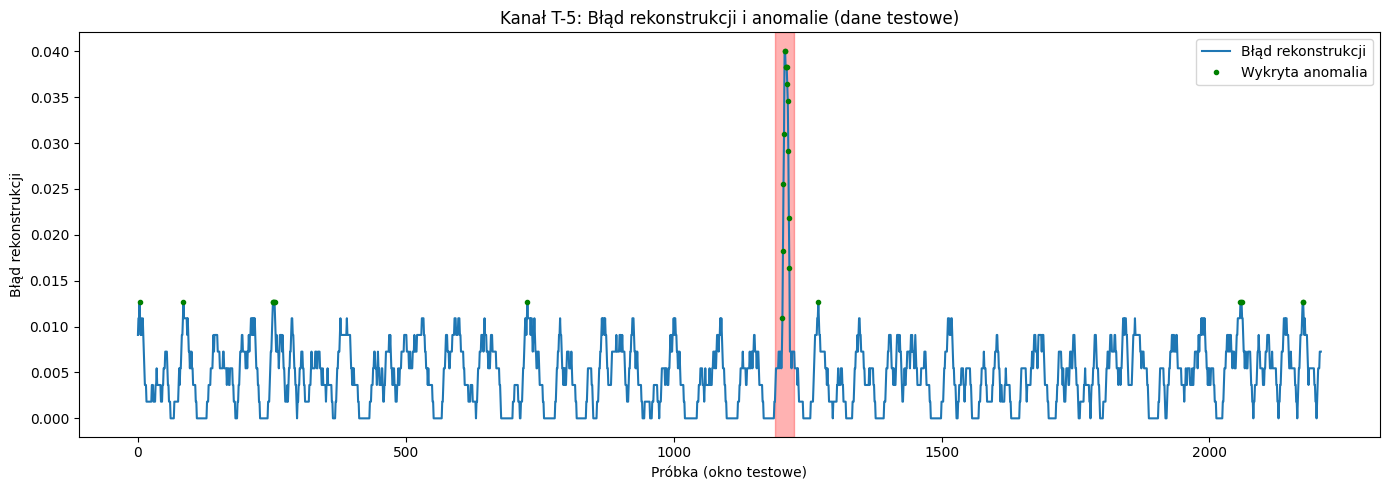

Confusion matrix (test):
[[2162   13]
 [  20   14]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      2175
     Anomaly       0.52      0.41      0.46        34

    accuracy                           0.99      2209
   macro avg       0.75      0.70      0.73      2209
weighted avg       0.98      0.99      0.98      2209

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1200, 1225]: WYKRYTA

Czujnik: F-7
Epoch 10/80, Loss: 0.004306
Epoch 20/80, Loss: 0.004294
Epoch 30/80, Loss: 0.004273
Epoch 40/80, Loss: 0.004280
Epoch 50/80, Loss: 0.004286
Epoch 60/80, Loss: 0.004272
Epoch 70/80, Loss: 0.004273
Epoch 80/80, Loss: 0.004284
Threshold (percentyl 95) na danych testowych: 0.013725


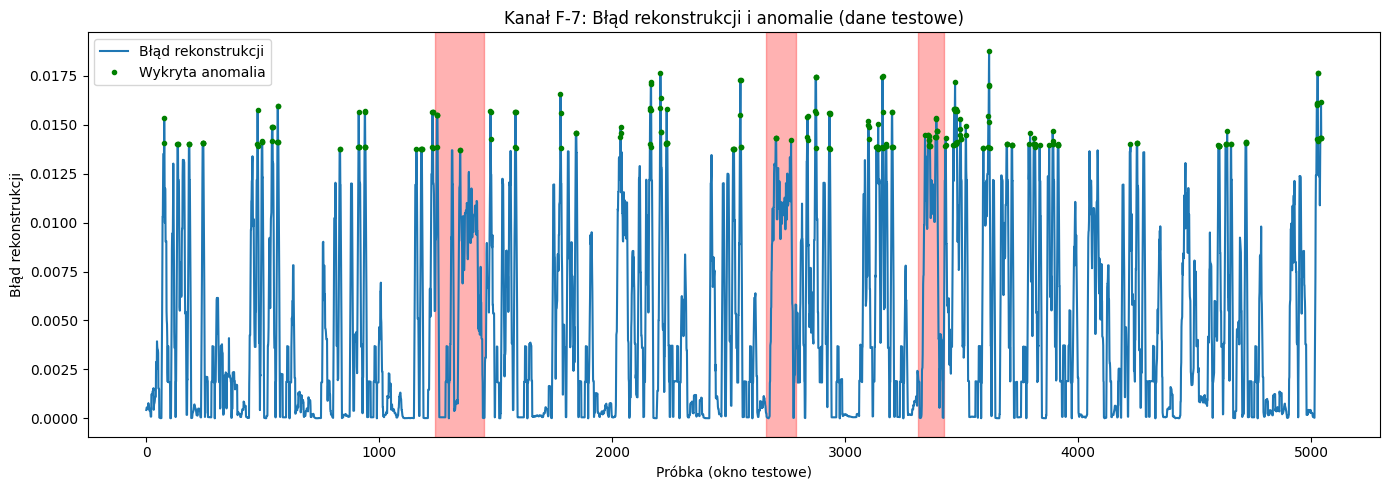

Confusion matrix (test):
[[4373  225]
 [ 419   28]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.91      0.95      0.93      4598
     Anomaly       0.11      0.06      0.08       447

    accuracy                           0.87      5045
   macro avg       0.51      0.51      0.51      5045
weighted avg       0.84      0.87      0.86      5045

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1450]: WYKRYTA
Anomalia [2670, 2790]: WYKRYTA
Anomalia [3325, 3425]: WYKRYTA

Czujnik: M-3
Epoch 10/80, Loss: 0.009082
Epoch 20/80, Loss: 0.009082
Epoch 30/80, Loss: 0.009079
Epoch 40/80, Loss: 0.009077
Epoch 50/80, Loss: 0.009078
Epoch 60/80, Loss: 0.009084
Epoch 70/80, Loss: 0.009079
Epoch 80/80, Loss: 0.009076
Threshold (percentyl 95) na danych testowych: 0.019959


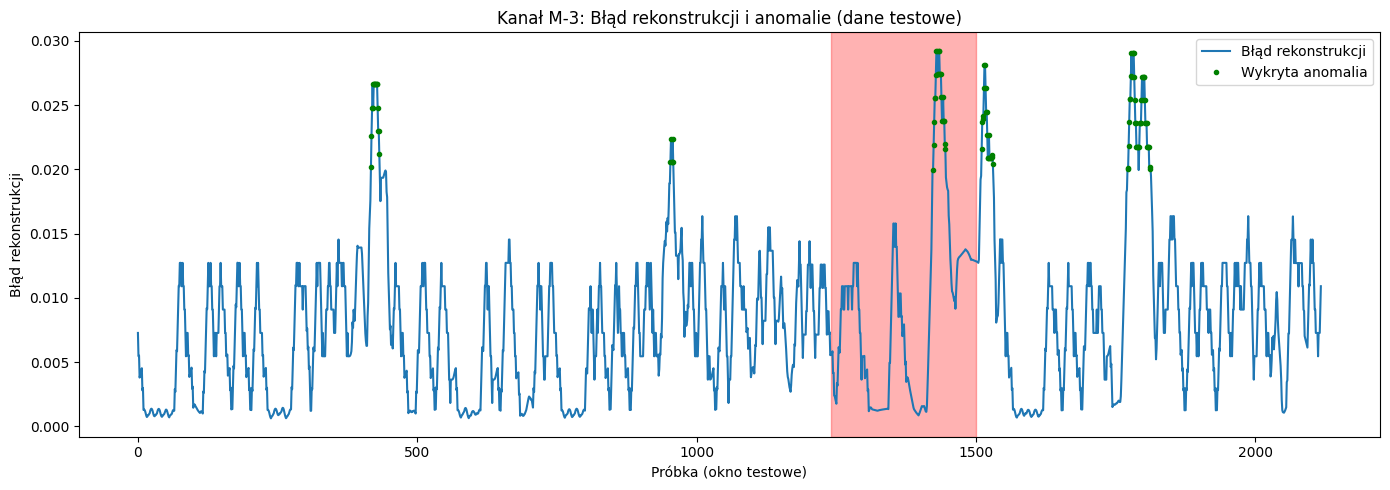

Confusion matrix (test):
[[1776   83]
 [ 236   23]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.88      0.96      0.92      1859
     Anomaly       0.22      0.09      0.13       259

    accuracy                           0.85      2118
   macro avg       0.55      0.52      0.52      2118
weighted avg       0.80      0.85      0.82      2118

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1500]: WYKRYTA

Czujnik: M-4
Epoch 10/80, Loss: 0.008523
Epoch 20/80, Loss: 0.008573
Epoch 30/80, Loss: 0.008480
Epoch 40/80, Loss: 0.008439
Epoch 50/80, Loss: 0.008683
Epoch 60/80, Loss: 0.008552
Epoch 70/80, Loss: 0.008563
Epoch 80/80, Loss: 0.008547
Threshold (percentyl 95) na danych testowych: 0.016876


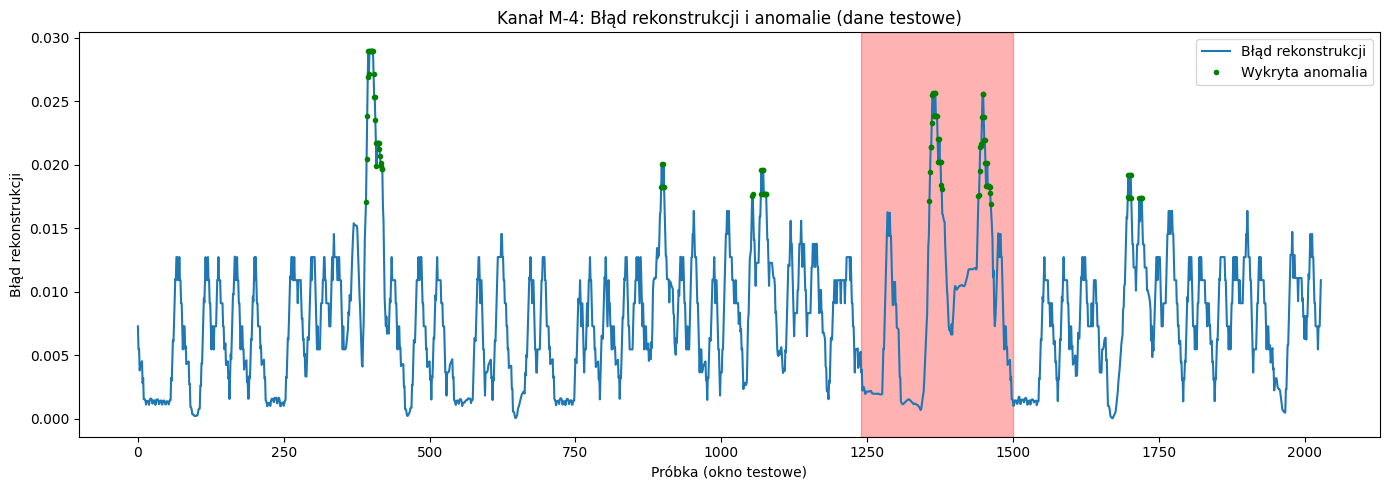

Confusion matrix (test):
[[1712   58]
 [ 215   44]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.89      0.97      0.93      1770
     Anomaly       0.43      0.17      0.24       259

    accuracy                           0.87      2029
   macro avg       0.66      0.57      0.58      2029
weighted avg       0.83      0.87      0.84      2029

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1500]: WYKRYTA

Czujnik: M-5
Epoch 10/80, Loss: 0.009085
Epoch 20/80, Loss: 0.006235
Epoch 30/80, Loss: 0.006145
Epoch 40/80, Loss: 0.006121
Epoch 50/80, Loss: 0.006109
Epoch 60/80, Loss: 0.006072
Epoch 70/80, Loss: 0.006038
Epoch 80/80, Loss: 0.005650
Threshold (percentyl 95) na danych testowych: 0.012366


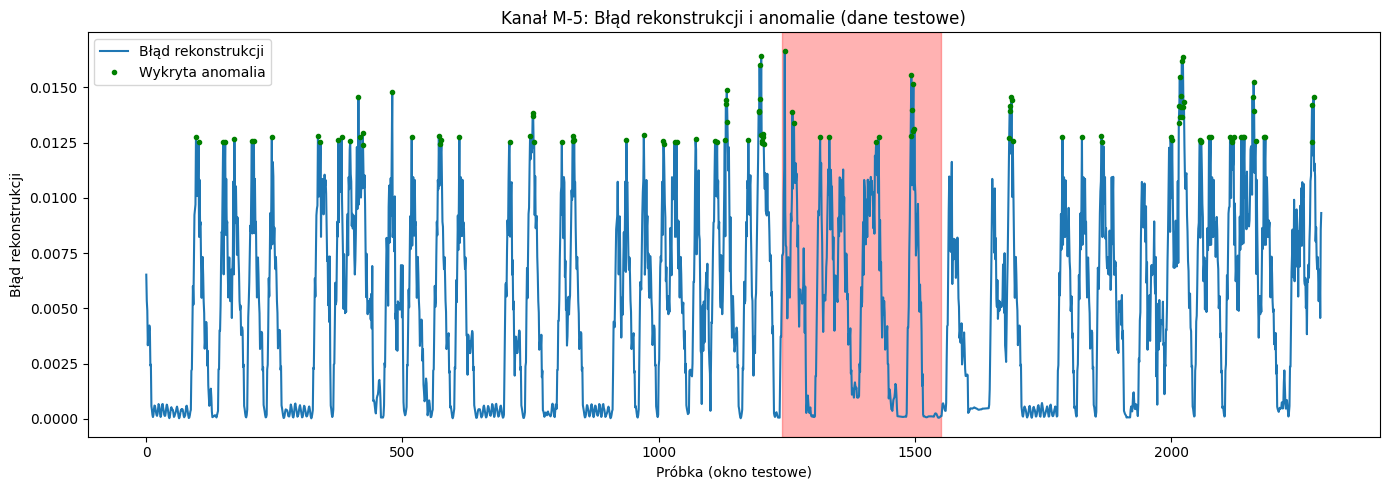

Confusion matrix (test):
[[1883  102]
 [ 296   13]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.86      0.95      0.90      1985
     Anomaly       0.11      0.04      0.06       309

    accuracy                           0.83      2294
   macro avg       0.49      0.50      0.48      2294
weighted avg       0.76      0.83      0.79      2294

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1550]: WYKRYTA

Czujnik: P-15
Epoch 10/80, Loss: 0.002635
Epoch 20/80, Loss: 0.002636
Epoch 30/80, Loss: 0.002636
Epoch 40/80, Loss: 0.002638
Epoch 50/80, Loss: 0.002635
Epoch 60/80, Loss: 0.002634
Epoch 70/80, Loss: 0.002639
Epoch 80/80, Loss: 0.002633
Threshold (percentyl 95) na danych testowych: 0.959769


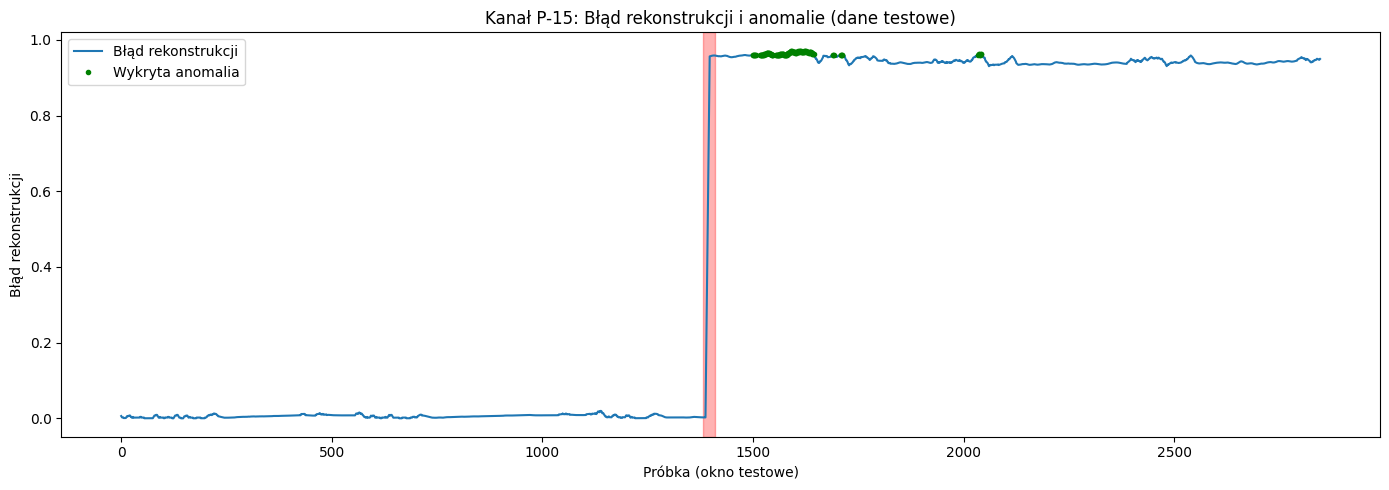

Confusion matrix (test):
[[2675  143]
 [  29    0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97      2818
     Anomaly       0.00      0.00      0.00        29

    accuracy                           0.94      2847
   macro avg       0.49      0.47      0.48      2847
weighted avg       0.98      0.94      0.96      2847

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1390, 1410]: NIEWYKRYTA

Czujnik: C-1
Epoch 10/80, Loss: 0.005232
Epoch 20/80, Loss: 0.005239
Epoch 30/80, Loss: 0.005229
Epoch 40/80, Loss: 0.005218
Epoch 50/80, Loss: 0.005234
Epoch 60/80, Loss: 0.005232
Epoch 70/80, Loss: 0.005224
Epoch 80/80, Loss: 0.005229
Threshold (percentyl 95) na danych testowych: 0.014546


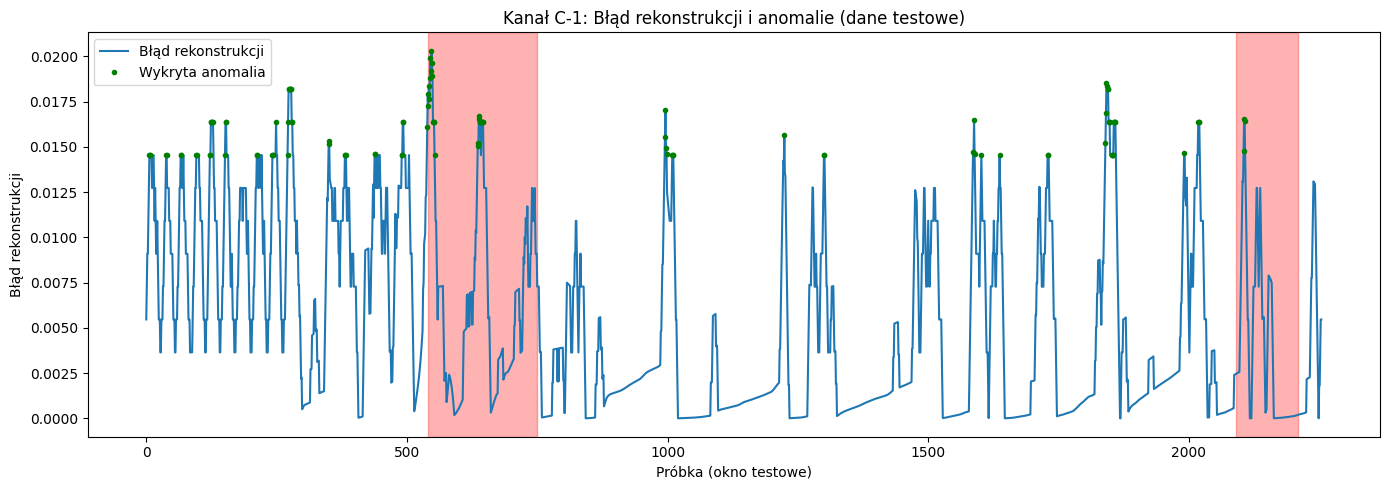

Confusion matrix (test):
[[1840   87]
 [ 302   26]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.86      0.95      0.90      1927
     Anomaly       0.23      0.08      0.12       328

    accuracy                           0.83      2255
   macro avg       0.54      0.52      0.51      2255
weighted avg       0.77      0.83      0.79      2255

Wynik sprawdzania anomalii względem metadanych:
Anomalia [550, 750]: WYKRYTA
Anomalia [2100, 2210]: WYKRYTA

Czujnik: C-2
Epoch 10/80, Loss: 0.012674
Epoch 20/80, Loss: 0.012677
Epoch 30/80, Loss: 0.012676
Epoch 40/80, Loss: 0.012666
Epoch 50/80, Loss: 0.012672
Epoch 60/80, Loss: 0.012677
Epoch 70/80, Loss: 0.012685
Epoch 80/80, Loss: 0.012676
Threshold (percentyl 95) na danych testowych: 0.033716


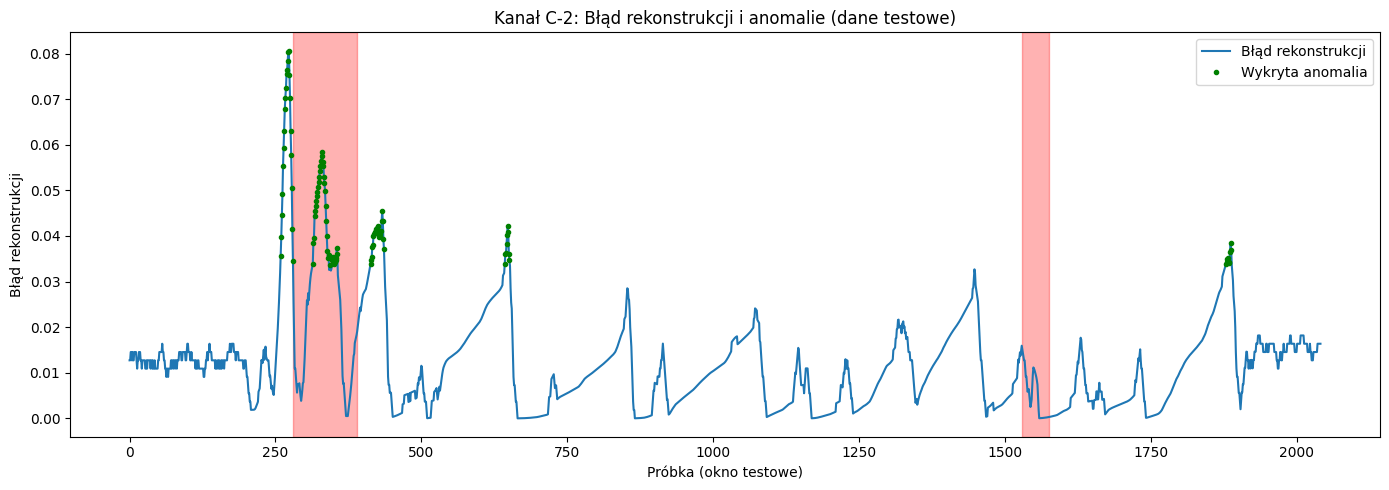

Confusion matrix (test):
[[1825   64]
 [ 114   39]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.95      1889
     Anomaly       0.38      0.25      0.30       153

    accuracy                           0.91      2042
   macro avg       0.66      0.61      0.63      2042
weighted avg       0.90      0.91      0.90      2042

Wynik sprawdzania anomalii względem metadanych:
Anomalia [290, 390]: WYKRYTA
Anomalia [1540, 1575]: NIEWYKRYTA

Czujnik: T-12
Epoch 10/80, Loss: 0.001865
Epoch 20/80, Loss: 0.000870
Epoch 30/80, Loss: 0.000862
Epoch 40/80, Loss: 0.000859
Epoch 50/80, Loss: 0.000858
Epoch 60/80, Loss: 0.000861
Epoch 70/80, Loss: 0.000857
Epoch 80/80, Loss: 0.000860
Threshold (percentyl 95) na danych testowych: 0.004727


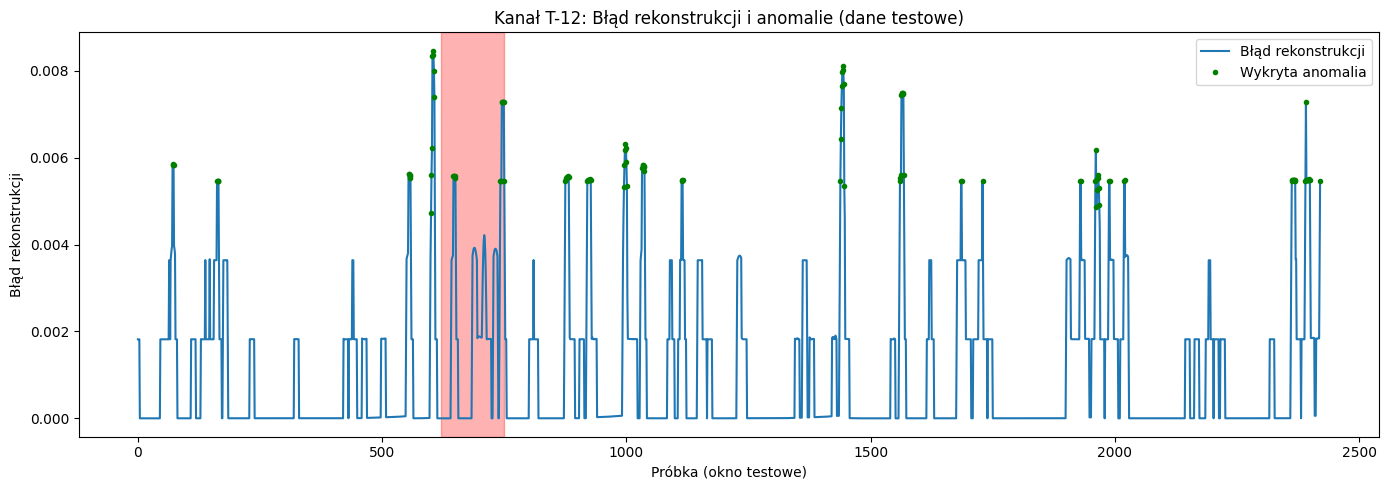

Confusion matrix (test):
[[2184  108]
 [ 116   13]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95      2292
     Anomaly       0.11      0.10      0.10       129

    accuracy                           0.91      2421
   macro avg       0.53      0.53      0.53      2421
weighted avg       0.90      0.91      0.91      2421

Wynik sprawdzania anomalii względem metadanych:
Anomalia [630, 750]: WYKRYTA

Czujnik: T-13
Epoch 10/80, Loss: 0.001871
Epoch 20/80, Loss: 0.001369
Epoch 30/80, Loss: 0.000842
Epoch 40/80, Loss: 0.000834
Epoch 50/80, Loss: 0.000835
Epoch 60/80, Loss: 0.000837
Epoch 70/80, Loss: 0.000830
Epoch 80/80, Loss: 0.000832
Threshold (percentyl 95) na danych testowych: 0.003669


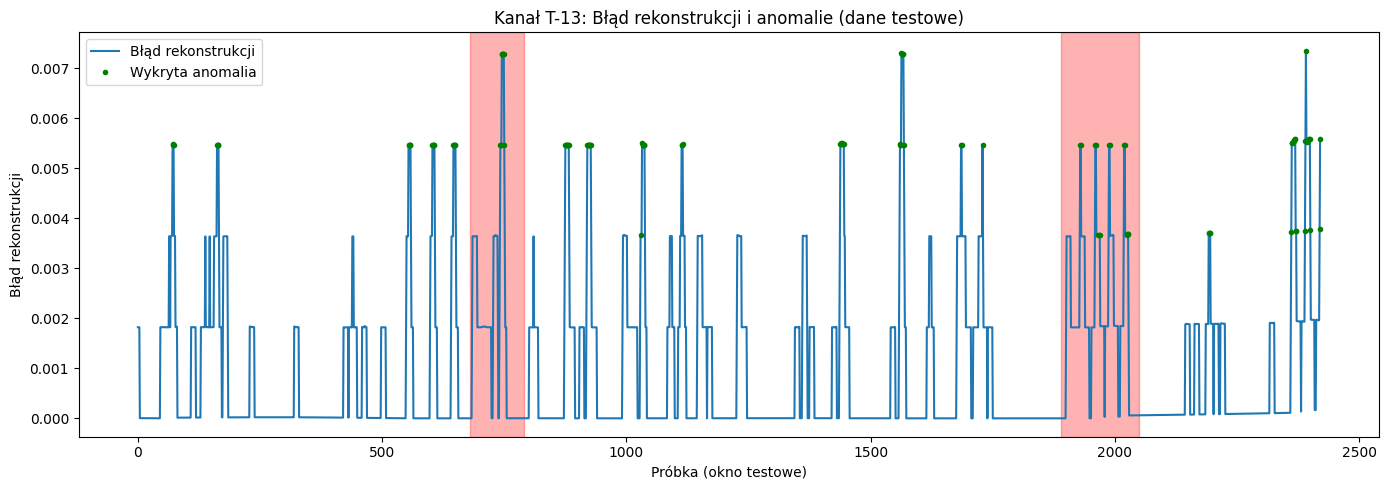

Confusion matrix (test):
[[2056   97]
 [ 244   24]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.89      0.95      0.92      2153
     Anomaly       0.20      0.09      0.12       268

    accuracy                           0.86      2421
   macro avg       0.55      0.52      0.52      2421
weighted avg       0.82      0.86      0.83      2421

Wynik sprawdzania anomalii względem metadanych:
Anomalia [690, 790]: WYKRYTA
Anomalia [1900, 2050]: WYKRYTA

Czujnik: F-4
Epoch 10/80, Loss: 0.004246
Epoch 20/80, Loss: 0.004241
Epoch 30/80, Loss: 0.004242
Epoch 40/80, Loss: 0.004230
Epoch 50/80, Loss: 0.004240
Epoch 60/80, Loss: 0.004255
Epoch 70/80, Loss: 0.004232
Epoch 80/80, Loss: 0.004240
Threshold (percentyl 95) na danych testowych: 0.019626


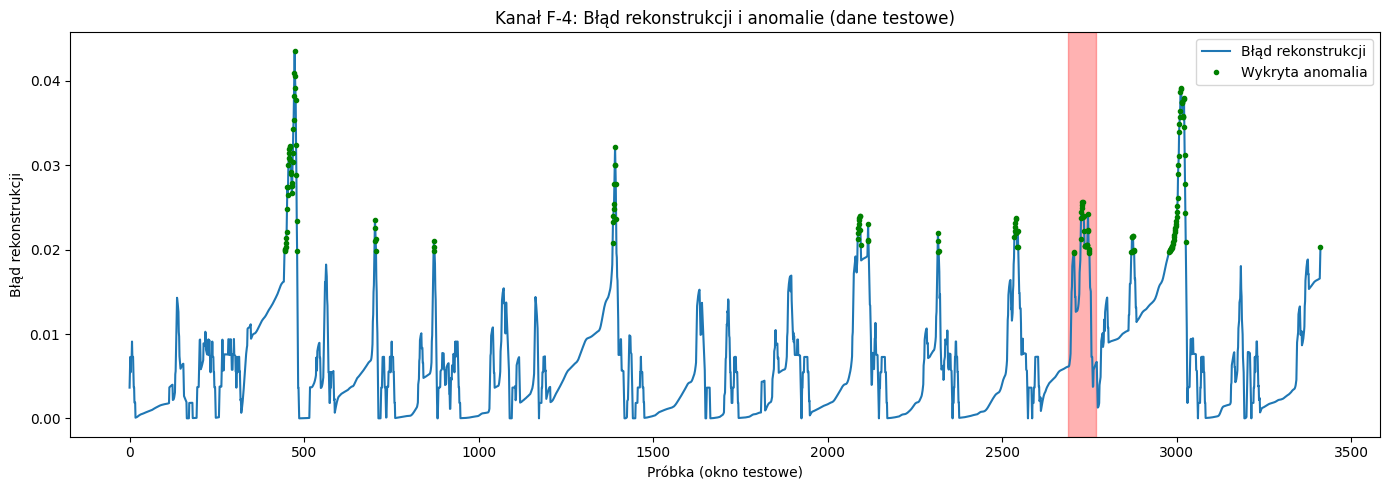

Confusion matrix (test):
[[3191  143]
 [  51   28]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97      3334
     Anomaly       0.16      0.35      0.22        79

    accuracy                           0.94      3413
   macro avg       0.57      0.66      0.60      3413
weighted avg       0.97      0.94      0.95      3413

Wynik sprawdzania anomalii względem metadanych:
Anomalia [2700, 2770]: WYKRYTA

Czujnik: F-5
Epoch 10/80, Loss: 0.003114
Epoch 20/80, Loss: 0.003087
Epoch 30/80, Loss: 0.003114
Epoch 40/80, Loss: 0.003113
Epoch 50/80, Loss: 0.003084
Epoch 60/80, Loss: 0.003077
Epoch 70/80, Loss: 0.003106
Epoch 80/80, Loss: 0.003078
Threshold (percentyl 95) na danych testowych: 0.007913


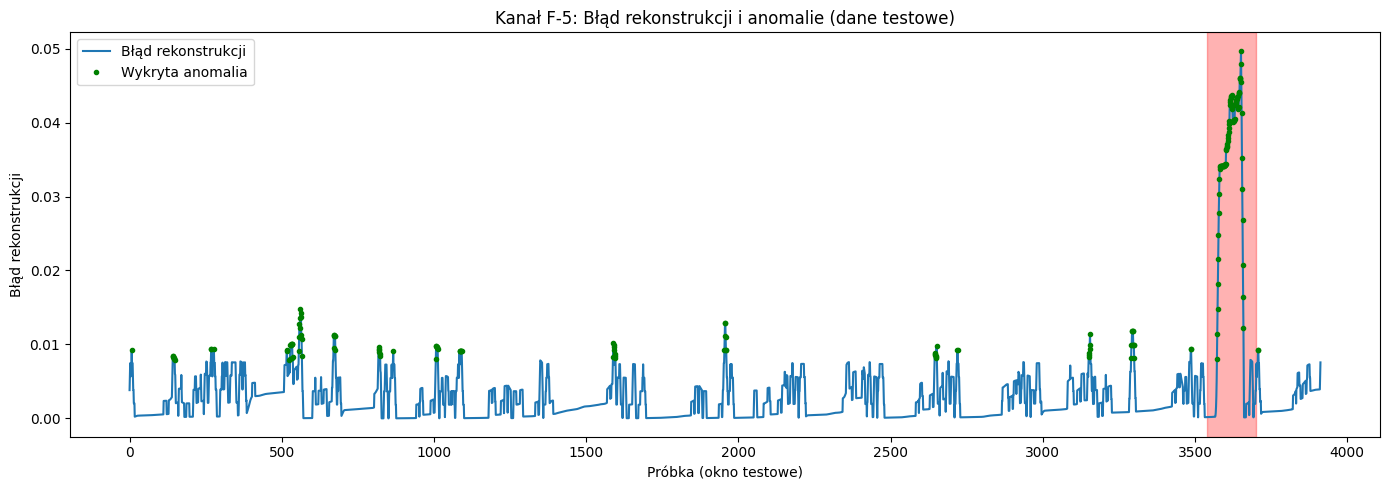

Confusion matrix (test):
[[3646  108]
 [  71   88]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98      3754
     Anomaly       0.45      0.55      0.50       159

    accuracy                           0.95      3913
   macro avg       0.71      0.76      0.74      3913
weighted avg       0.96      0.95      0.96      3913

Wynik sprawdzania anomalii względem metadanych:
Anomalia [3550, 3700]: WYKRYTA

Czujnik: D-14
Epoch 10/80, Loss: 0.005159
Epoch 20/80, Loss: 0.005158
Epoch 30/80, Loss: 0.005170
Epoch 40/80, Loss: 0.005161
Epoch 50/80, Loss: 0.005167
Epoch 60/80, Loss: 0.005171
Epoch 70/80, Loss: 0.005171
Epoch 80/80, Loss: 0.005141
Threshold (percentyl 95) na danych testowych: 0.072727


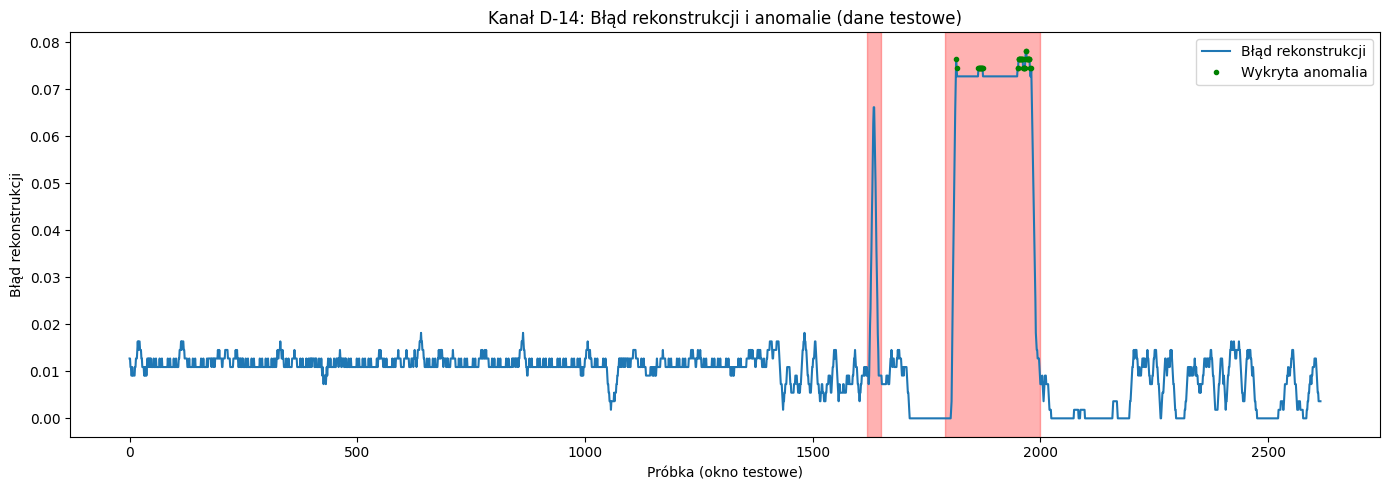

Confusion matrix (test):
[[2378    0]
 [ 197   41]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96      2378
     Anomaly       1.00      0.17      0.29       238

    accuracy                           0.92      2616
   macro avg       0.96      0.59      0.63      2616
weighted avg       0.93      0.92      0.90      2616

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1630, 1650]: NIEWYKRYTA
Anomalia [1800, 2000]: WYKRYTA

Czujnik: T-9
Epoch 10/80, Loss: 0.013223
Epoch 20/80, Loss: 0.012493
Epoch 30/80, Loss: 0.012456
Epoch 40/80, Loss: 0.012471
Epoch 50/80, Loss: 0.012026
Epoch 60/80, Loss: 0.012157
Epoch 70/80, Loss: 0.011676
Epoch 80/80, Loss: 0.008933
Threshold (percentyl 95) na danych testowych: 0.015493


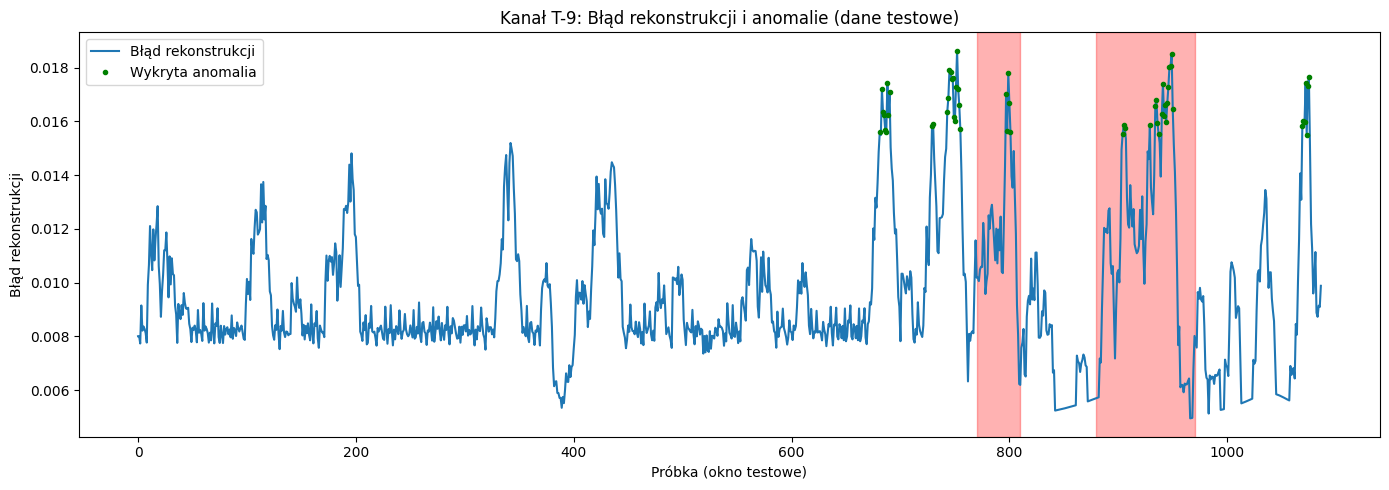

Confusion matrix (test):
[[928  31]
 [104  24]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.90      0.97      0.93       959
     Anomaly       0.44      0.19      0.26       128

    accuracy                           0.88      1087
   macro avg       0.67      0.58      0.60      1087
weighted avg       0.84      0.88      0.85      1087

Wynik sprawdzania anomalii względem metadanych:
Anomalia [780, 810]: WYKRYTA
Anomalia [890, 970]: WYKRYTA

Czujnik: P-14
Epoch 10/80, Loss: 0.002366
Epoch 20/80, Loss: 0.001983
Epoch 30/80, Loss: 0.001636
Epoch 40/80, Loss: 0.001495
Epoch 50/80, Loss: 0.001368
Epoch 60/80, Loss: 0.001399
Epoch 70/80, Loss: 0.001322
Epoch 80/80, Loss: 0.001296
Threshold (percentyl 95) na danych testowych: 55476.337453


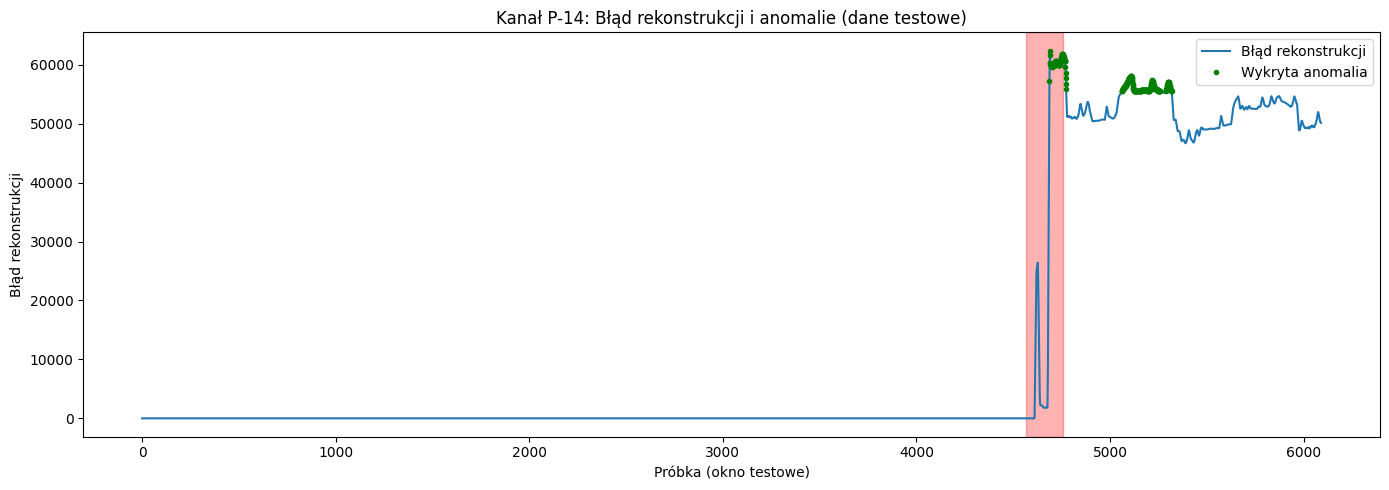

Confusion matrix (test):
[[5665  237]
 [ 121   68]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97      5902
     Anomaly       0.22      0.36      0.28       189

    accuracy                           0.94      6091
   macro avg       0.60      0.66      0.62      6091
weighted avg       0.96      0.94      0.95      6091

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4575, 4755]: WYKRYTA

Czujnik: T-8
Epoch 10/80, Loss: 0.011135
Epoch 20/80, Loss: 0.011132
Epoch 30/80, Loss: 0.011150
Epoch 40/80, Loss: 0.011129
Epoch 50/80, Loss: 0.011138
Epoch 60/80, Loss: 0.011129
Epoch 70/80, Loss: 0.011121
Epoch 80/80, Loss: 0.011108
Threshold (percentyl 95) na danych testowych: 0.014476


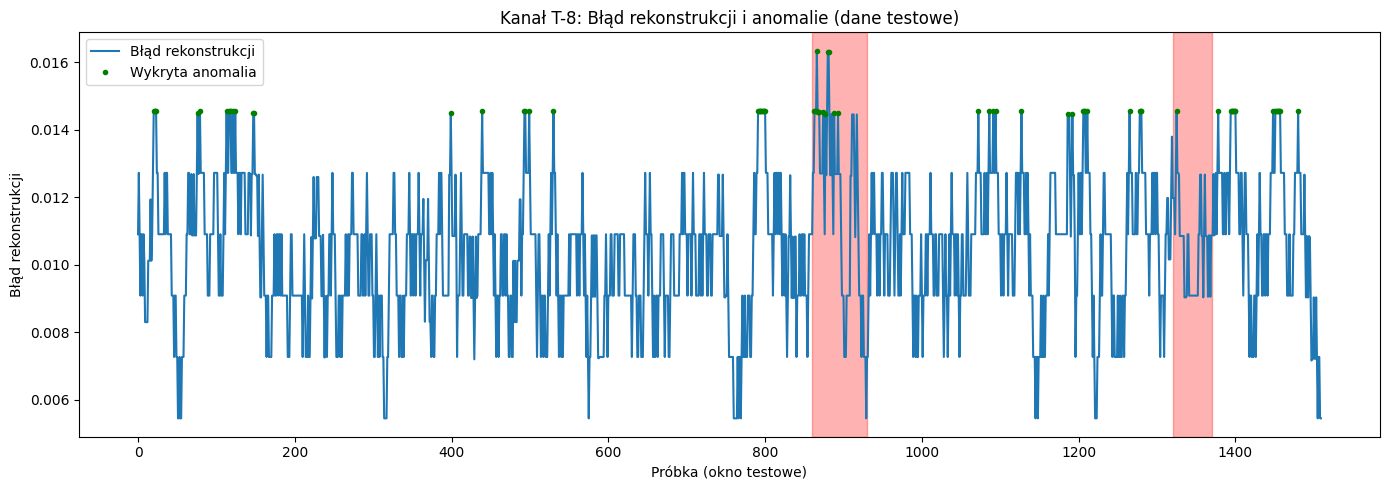

Confusion matrix (test):
[[1330   62]
 [ 104   14]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.93      0.96      0.94      1392
     Anomaly       0.18      0.12      0.14       118

    accuracy                           0.89      1510
   macro avg       0.56      0.54      0.54      1510
weighted avg       0.87      0.89      0.88      1510

Wynik sprawdzania anomalii względem metadanych:
Anomalia [870, 930]: WYKRYTA
Anomalia [1330, 1370]: WYKRYTA

Czujnik: P-11
Epoch 10/80, Loss: 0.003018
Epoch 20/80, Loss: 0.003018
Epoch 30/80, Loss: 0.003018
Epoch 40/80, Loss: 0.003018
Epoch 50/80, Loss: 0.003018
Epoch 60/80, Loss: 0.003019
Epoch 70/80, Loss: 0.003019
Epoch 80/80, Loss: 0.003017
Threshold (percentyl 95) na danych testowych: 0.009177


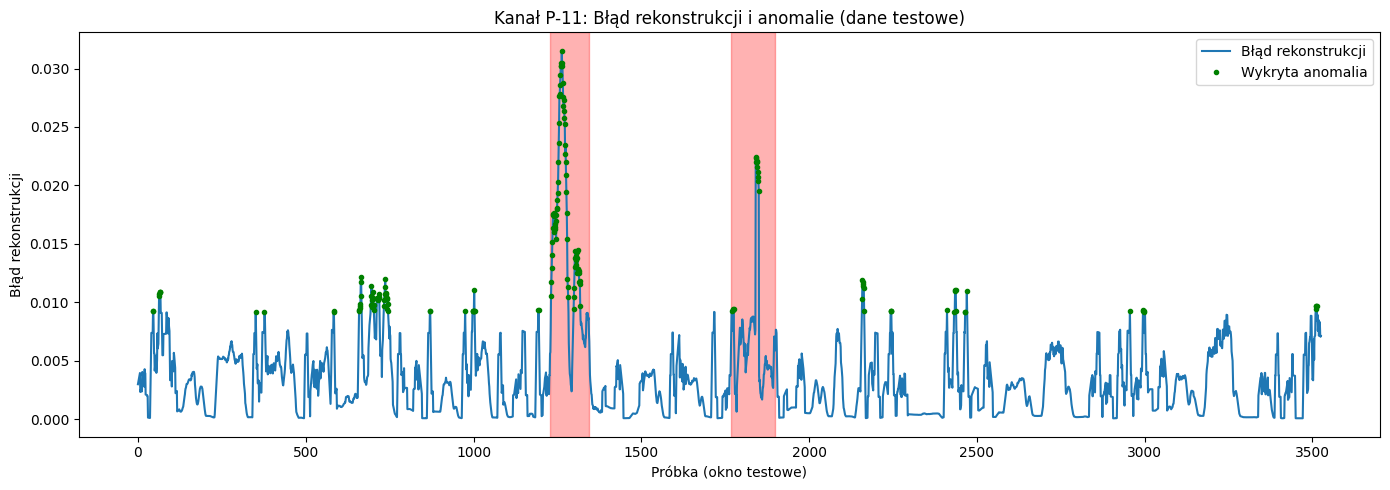

Confusion matrix (test):
[[3192   90]
 [ 157   87]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96      3282
     Anomaly       0.49      0.36      0.41       244

    accuracy                           0.93      3526
   macro avg       0.72      0.66      0.69      3526
weighted avg       0.92      0.93      0.92      3526

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1778, 1898]: WYKRYTA
Anomalia [1238, 1344]: WYKRYTA

Czujnik: D-15
Epoch 10/80, Loss: 0.007454
Epoch 20/80, Loss: 0.007350
Epoch 30/80, Loss: 0.007410
Epoch 40/80, Loss: 0.007376
Epoch 50/80, Loss: 0.007328
Epoch 60/80, Loss: 0.007452
Epoch 70/80, Loss: 0.007650
Epoch 80/80, Loss: 0.007458
Threshold (percentyl 95) na danych testowych: 0.020238


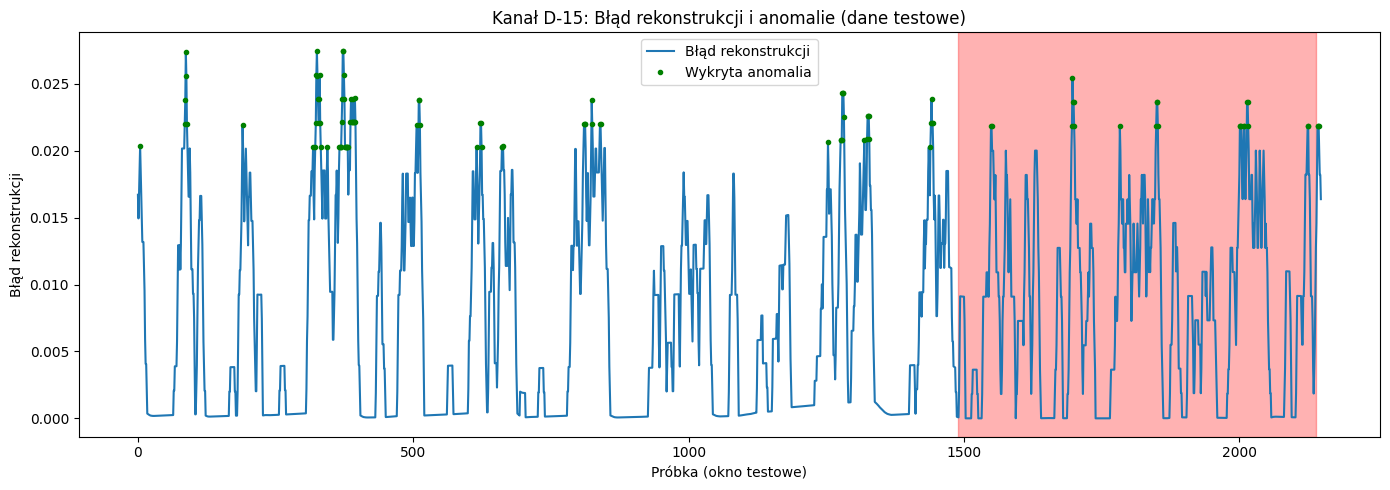

Confusion matrix (test):
[[1414   86]
 [ 627   22]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.69      0.94      0.80      1500
     Anomaly       0.20      0.03      0.06       649

    accuracy                           0.67      2149
   macro avg       0.45      0.49      0.43      2149
weighted avg       0.55      0.67      0.58      2149

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1500, 2140]: WYKRYTA

Czujnik: D-16
Epoch 10/80, Loss: 0.015856
Epoch 20/80, Loss: 0.015909
Epoch 30/80, Loss: 0.015860
Epoch 40/80, Loss: 0.015873
Epoch 50/80, Loss: 0.015782
Epoch 60/80, Loss: 0.015880
Epoch 70/80, Loss: 0.015904
Epoch 80/80, Loss: 0.015852
Threshold (percentyl 95) na danych testowych: 0.020259


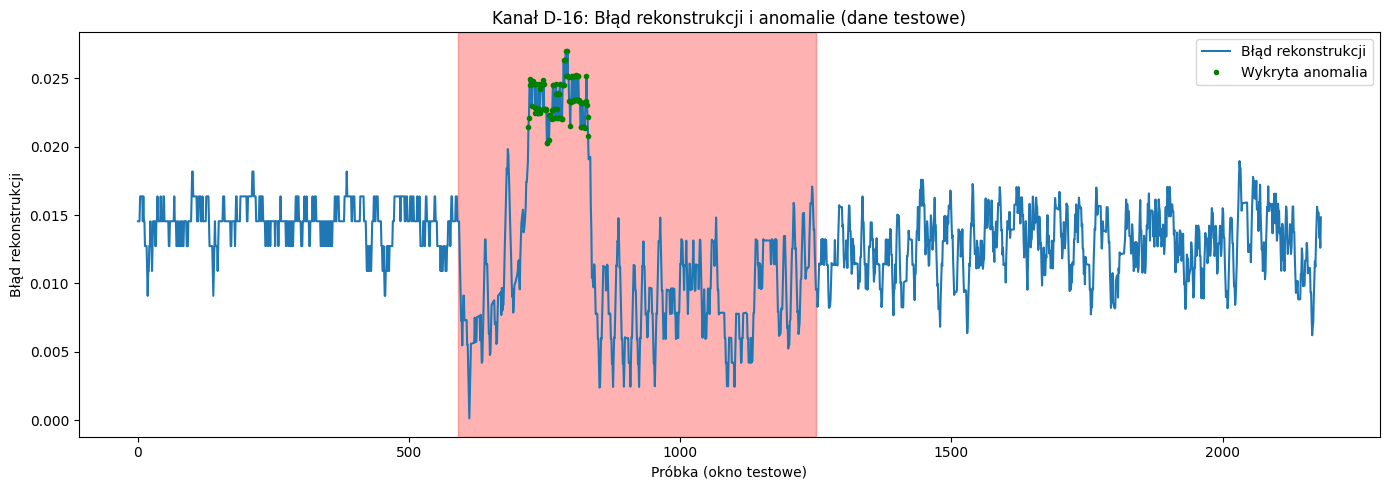

Confusion matrix (test):
[[1523    0]
 [ 549  110]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.74      1.00      0.85      1523
     Anomaly       1.00      0.17      0.29       659

    accuracy                           0.75      2182
   macro avg       0.87      0.58      0.57      2182
weighted avg       0.82      0.75      0.68      2182

Wynik sprawdzania anomalii względem metadanych:
Anomalia [600, 1250]: WYKRYTA

Czujnik: M-7
Epoch 10/80, Loss: 0.008758
Epoch 20/80, Loss: 0.008783
Epoch 30/80, Loss: 0.008776
Epoch 40/80, Loss: 0.008789
Epoch 50/80, Loss: 0.008784
Epoch 60/80, Loss: 0.008768
Epoch 70/80, Loss: 0.008840
Epoch 80/80, Loss: 0.008787
Threshold (percentyl 95) na danych testowych: 0.014546


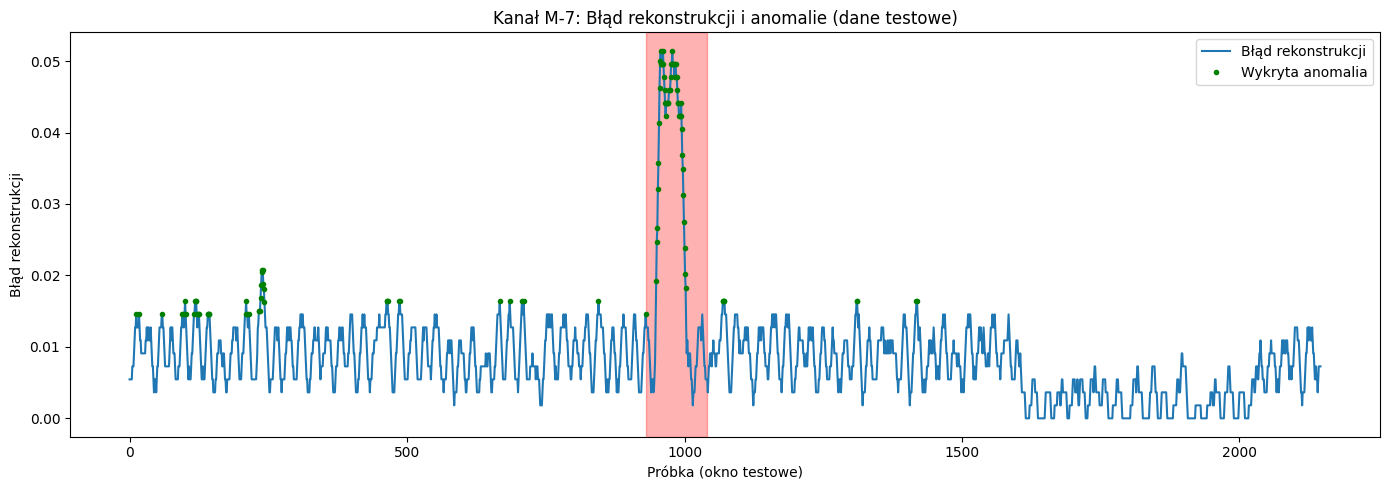

Confusion matrix (test):
[[1985   53]
 [  55   54]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      2038
     Anomaly       0.50      0.50      0.50       109

    accuracy                           0.95      2147
   macro avg       0.74      0.73      0.74      2147
weighted avg       0.95      0.95      0.95      2147

Wynik sprawdzania anomalii względem metadanych:
Anomalia [940, 1040]: WYKRYTA

Czujnik: F-8
Epoch 10/80, Loss: 0.003053
Epoch 20/80, Loss: 0.003014
Epoch 30/80, Loss: 0.003003
Epoch 40/80, Loss: 0.003130
Epoch 50/80, Loss: 0.003149
Epoch 60/80, Loss: 0.002971
Epoch 70/80, Loss: 0.003017
Epoch 80/80, Loss: 0.003033
Threshold (percentyl 95) na danych testowych: 0.009913


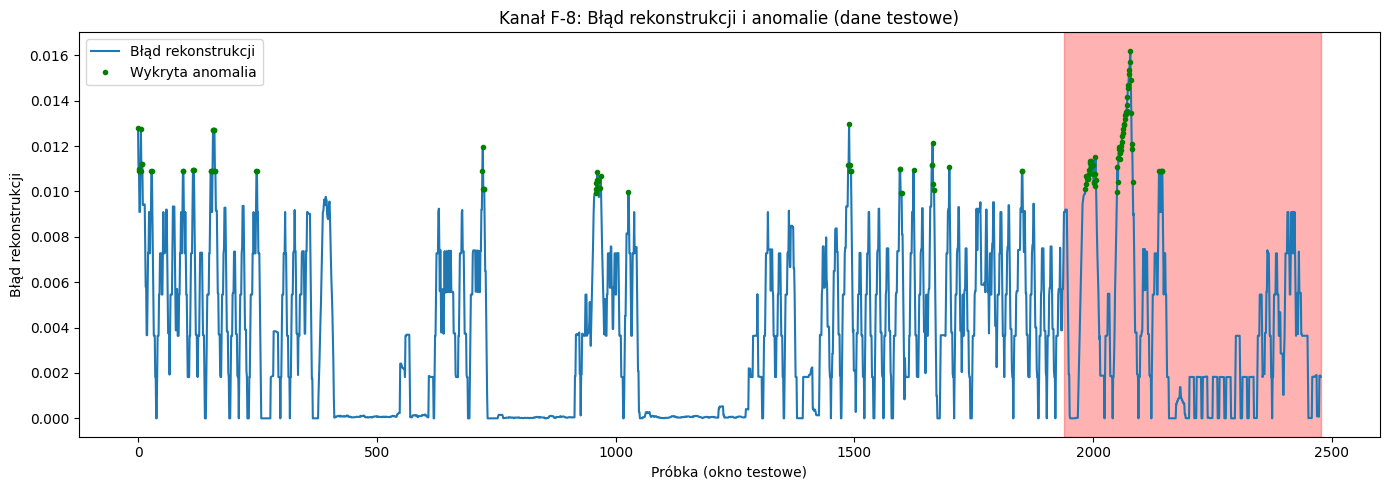

Confusion matrix (test):
[[1878   63]
 [ 476   61]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.80      0.97      0.87      1941
     Anomaly       0.49      0.11      0.18       537

    accuracy                           0.78      2478
   macro avg       0.64      0.54      0.53      2478
weighted avg       0.73      0.78      0.72      2478

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1950, 2486]: WYKRYTA

PODSUMOWANIE DLA WSZYSTKICH CZUJNIKÓW
Wszystkich anomalii:: 36
Wykrytych anomalii:: 33
Niewykrytych anomali: 3


In [ ]:
# Parametry do ustawienia
batch_size = 128
epochs = 80 
threshold_percentile = 95
window_size = 10
window_step = 1 
learning_rate = 1e-3 

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import csv
import numpy as np

# Funkcja tworząca okna czasowe
def create_windows(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

# Definicja modelu Autoenkodera
class UniversalAE(nn.Module):
    def __init__(self, input_dim):
        super(UniversalAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

total_anomalies = 0
detected_anomalies = 0
results = []

# Pętla po wszystkich czujnikach
for sensor_name in msl_channels:
    print(f"\n{'='*40}\nCzujnik: {sensor_name}\n{'='*40}")

    # Przygotowanie danych
    train_data = msl_train_data[sensor_name]
    sensor_test_data = msl_test_data[sensor_name]

    scaler = MinMaxScaler()
    arr_norm = scaler.fit_transform(train_data)
    arr_test_norm = scaler.transform(sensor_test_data)

    # Tworzenie okien czasowych
    arr_norm_windows = create_windows(arr_norm, window_size, window_step)
    arr_test_norm_windows = create_windows(arr_test_norm, window_size, window_step)
    
    arr_norm_windows = arr_norm_windows.reshape(arr_norm_windows.shape[0], -1)
    arr_test_norm_windows = arr_test_norm_windows.reshape(arr_test_norm_windows.shape[0], -1)
    input_dim = arr_norm_windows.shape[1]

    # Nauka modelu
    model = UniversalAE(input_dim).to(device)
    X_train = torch.tensor(arr_norm_windows, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), learning_rate)
    criterion = nn.MSELoss()

    display_steps = 8
    step_interval = max(1, epochs // display_steps)

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x_batch = batch[0]
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % step_interval == 0 or epoch == epochs - 1:
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    # Testowanie modelu
    X_test = torch.tensor(arr_test_norm_windows, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        recon_test = model(X_test).cpu().numpy()
    
    # Błąd rekonstrukcji i threshold na danych testowych (threshold ustalany na danych testowych aby uniknąć błędów związanych z liczeniem precyzji w momencie gdy nie wykryto anomalii w danych)
    # Licząc threshold na danych testwowych gwarantujemy przynajmniej jedną wykrytą anomalię (niekoniecznie prawdziwą)
    test_recon_error = np.mean((arr_test_norm_windows - recon_test) ** 2, axis=1)
    threshold = np.percentile(test_recon_error, threshold_percentile)
    print(f"Threshold (percentyl {threshold_percentile}) na danych testowych: {threshold:.6f}")

    # Wykrywanie anomalii
    predicted_anomaly = (test_recon_error > threshold).astype(int)

    # Prawdziwe anomalie z labeled_anomalies.csv
    anomaly_row = metadata[metadata['chan_id'] == sensor_name]
    anomaly_sequences = []
    if not anomaly_row.empty:
        anomaly_sequences = eval(anomaly_row.iloc[0]['anomaly_sequences'])

    true_anomaly = np.zeros(len(test_recon_error), dtype=int)
    for seq in anomaly_sequences:
        start, end = seq
        for i, win_start in enumerate(range(0, len(sensor_test_data) - window_size + 1, window_step)):
            win_end = win_start + window_size
            if (start < win_end) and (end > win_start):
                true_anomaly[i] = 1

    # Wizualizacja
    plt.figure(figsize=(14, 5))
    plt.plot(test_recon_error, label="Błąd rekonstrukcji")
    for seq in anomaly_sequences:
        start, end = seq
        start_win = max(0, (start - window_size) // window_step)
        end_win = min(len(test_recon_error)-1, end // window_step)
        plt.axvspan(start_win, end_win, color='red', alpha=0.3)
    plt.plot(np.where(predicted_anomaly == 1)[0], test_recon_error[predicted_anomaly == 1], 'g.', label="Wykryta anomalia")
    plt.title(f"Kanał {sensor_name}: Błąd rekonstrukcji i anomalie (dane testowe)")
    plt.xlabel("Próbka (okno testowe)")
    plt.ylabel("Błąd rekonstrukcji")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Confusion matrix (test):")
    print(confusion_matrix(true_anomaly, predicted_anomaly))
    print("\nClassification report (test):")
    print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

    # Sprawdzenie wykrycia wszystkich anomalii
    detected_ranges = []
    for seq in anomaly_sequences:
        start, end = seq
        for i, win_start in enumerate(range(0, len(sensor_test_data) - window_size + 1, window_step)):
            win_end = win_start + window_size
            if (start < win_end) and (end > win_start) and predicted_anomaly[i] == 1:
                detected_ranges.append(seq)
                break

    print("Wynik sprawdzania anomalii względem metadanych:")
    for seq in anomaly_sequences:
        if seq in detected_ranges:
            print(f"Anomalia {seq}: WYKRYTA")
        else:
            print(f"Anomalia {seq}: NIEWYKRYTA")

    total_anomalies += len(anomaly_sequences)
    detected_anomalies += len(detected_ranges)

    report = classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"], output_dict=True)
    cm = confusion_matrix(true_anomaly, predicted_anomaly)

    # Zapis metryk
    results.append({
        "sensor": sensor_name,
        "accuracy": report["accuracy"],
        "f1_normal": report["Normal"]["f1-score"],
        "f1_anomaly": report["Anomaly"]["f1-score"],
        "precision_normal": report["Normal"]["precision"],
        "precision_anomaly": report["Anomaly"]["precision"],
        "recall_normal": report["Normal"]["recall"],
        "recall_anomaly": report["Anomaly"]["recall"],
        "confusion_matrix": cm.tolist()
    })

# Zapis wyników do CSV
output_file = "results_metrics_1ch_1mod.csv"
with open(output_file, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=[
        "sensor", "accuracy", 
        "f1_normal", "f1_anomaly",
        "precision_normal", "precision_anomaly",
        "recall_normal", "recall_anomaly",
        "confusion_matrix"
    ])
    writer.writeheader()
    for row in results:
        writer.writerow(row)

print("\n" + "="*40)
print("PODSUMOWANIE DLA WSZYSTKICH CZUJNIKÓW")
print(f"Wszystkich anomalii:: {total_anomalies}")
print(f"Wykrytych anomalii:: {detected_anomalies}")
print(f"Niewykrytych anomali: {total_anomalies - detected_anomalies}")
print("="*40)
